In [1]:
import scipy.io
import numpy as np
import scipy as sp
import cupy as cp
import matplotlib.pyplot as plt
import os
from SWE_utils import *
from scipy.signal import firwin, butter, buttord, freqz

from arrus.ops.us4r import *
from arrus.ops.imaging import *
from arrus.metadata import *
from arrus.devices.probe import *
from arrus.devices.us4r import Us4RDTO
from arrus.utils.imaging import *

In [2]:
! nvidia-smi

Wed Jan 11 13:29:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    19W /  N/A |    282MiB /  5946MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
print(f"Device count: {cp.cuda.runtime.getDeviceCount()}")
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device: {device_props['name']} (cc {device_props['major']}.{device_props['minor']})")
print(f"GPU clock frequency: {device_props['clockRate']/1e3} MHz")
print(f"SM Count: {device_props['multiProcessorCount']}")
print("Available memory: ")
print(f"- global memory: {device_props['totalGlobalMem']/2**20} MiB")
print(f"- shared memory per thread block: {device_props['sharedMemPerBlock']} B")
print(f"- constant memory: {device_props['totalConstMem']} B")

Device count: 1
Device: b'GeForce RTX 3060 Laptop GPU' (cc 8.6)
GPU clock frequency: 1425.0 MHz
SM Count: 30
Available memory: 
- global memory: 5946.5625 MiB
- shared memory per thread block: 49152 B
- constant memory: 65536 B


# Script parameters
Configure the reconstruction parameters of individual steps of the algorithm

In [26]:
# General settings
dataset_id = 340
directory  = '../Datasets'

# Constants
c              = 1540.0
probe_elements = 128
probe_pitch    = 0.298e-3
fs             = 65e6

# Sequence parameters
pwi_txFreq   = 4.4e6
pwi_nCycles  = 2
pwi_txAngles = [-4.0, 0.0, 4.0]
pwi_txPri    = 100e-6
pwi_fri      = 2* pwi_txPri

# RF Filter
rf_filter_band        = [4e6, 7e6]    # Desired pass band, Hz
rf_filter_trans_width = 1e6           # Width of transition from pass band to stop band, Hz
rf_filter_numtaps     = 236           # Size of the FIR filter.

# Post down conversion IQ filtering
demod_filter_cutoff = 0.5 * 4.4e6       # Desired cutoff frequency, Hz
demod_filter_trans_width = 0.5 * 4.4e6  # Width of transition from pass band to stop band, Hz
demod_filter_numtaps = 128              # Size of the FIR filter.

# Beamforming
px_size = 0.1
x_grid = np.arange(-20, 20, px_size) * 1e-3
z_grid = np.arange(0, 50, px_size)   * 1e-3

# Shear wave detection
swd_mode              = 'kasai'
swd_zGate_length      = 8 
swd_ensemble_length   = 4

# Input parameters
df_sws_range = [0.5, 4.0];
df_f_range   = [40.0, 1000.0];
df_k_range   = 0.9;

# SWS estimation
swse_interp_factor = 10;
swse_interp_type   = 'cubic'
swse_d             = 30;
swse_frames        = [0, 99];
swse_SWV_range     = [0.5, 4.0];
swse_x_range       = [[0, 420], [0, 420]]

# Post-processing
median_filter_size = 20



## Load the dataset

In [5]:
# Load a dataset
sid = 'id' + str(dataset_id)
# Search for the file
for root, dirs, files in os.walk(directory):
    for file in files:
        if sid in file:
            file_path = os.path.join(root, file)
            data = sp.io.loadmat(file_path)

data["rf_data"].shape
rf = data["rf_data"]
rf = rf[np.newaxis, ...]
Nframes = rf.shape[1]
rf.shape


(1, 150, 4224, 128)

# Beamforming

### Design filters

In [6]:
## Function to plot the filter response
def plot_FIR_response(fs, taps, w, h):
    "Utility function to plot response functions"
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 9))
    ax0.plot(range(len(taps)), taps)
    ax0.set_xlabel("Tap")
    ax0.set_ylabel("Value")
    
    ax1.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax1.set_ylim(-80, 5)
    ax1.set_xlim(0, 0.5*fs)
    ax1.grid(True)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Gain (dB)')
    
    ax2.plot(0.5*fs*w/np.pi, np.angle(h))
    ax2.set_xlim(0, 0.5*fs)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Phase (rad)")

## Design a band-pass FIR filter for RF filtering of raw channel data
import_RF_filter_taps = 0    # Set to '1' to import filter taps from a file. If '0' a filter will be designed.

if(import_RF_filter_taps):
    # Import RF Band-pass FIR Filter coefficients
    RF_Filter_coeffs = scipy.io.loadmat("RF_Filter_coeffs.mat")
    rf_fir_taps = RF_Filter_coeffs["coeffs"]
    rf_fir_taps = np.squeeze(rf_fir_taps)
    
else:
    # Design a filter from the specification
    band = rf_filter_band                # Desired pass band, Hz
    trans_width = rf_filter_trans_width  # Width of transition from pass band to stop band, Hz
    numtaps = rf_filter_numtaps          # Size of the FIR filter.

    edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*fs]
    rf_fir_taps = signal.remez(numtaps, edges, [0, 1, 0], Hz=fs)
    if(0):
        w, h = signal.freqz(rf_fir_taps, [1], worN=2000)
        plot_FIR_response(fs, rf_fir_taps, w, h)

## Design a low-pass FIR filter for filtering of down-conversion products
# Specify the filter parameters    
cutoff = demod_filter_cutoff            # Desired cutoff frequency, Hz
trans_width = demod_filter_trans_width  # Width of transition from pass band to stop band, Hz
numtaps = demod_filter_numtaps          # Size of the FIR filter.
iq_fir_taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)
if(0):
    w, h = signal.freqz(iq_fir_taps, [1], worN=2000)
    plot_FIR_response(fs, iq_fir_taps, w, h)           

## Metadata

In [7]:
tx_angles = np.tile(pwi_txAngles, int(np.ceil(rf.shape[1]/len(pwi_txAngles))))*np.pi/180

sequence = PwiSequence(
    pulse=Pulse(center_frequency=pwi_txFreq, n_periods=pwi_nCycles, inverse=False),
    rx_sample_range=(0, rf.shape[1]),
    speed_of_sound=c, # [m/s],
    angles=tx_angles,
    pri=pwi_txPri
)

model=ProbeModel(
    model_id=ProbeModelId("atl", "l7-4"),
    n_elements=probe_elements,
    pitch=probe_pitch,
    curvature_radius=0,
)

probe = ProbeDTO(
    model=model
)

device=Us4RDTO(
    sampling_frequency=fs,
    probe=probe
)

context = arrus.metadata.FrameAcquisitionContext(
    device=device, 
    sequence=sequence,
    raw_sequence=None,
    medium=None,
    custom_data={})

data_desc=EchoDataDescription(
    sampling_frequency=fs,
)

metadata = ConstMetadata(context=context, data_desc=data_desc, input_shape=rf.shape, is_iq_data=False, dtype=np.int16, version=None)

## Pipeline: RF Filtering, Down-conversion and Beamforming

In [8]:
# Define the processing pipeline
processing = Pipeline(
    steps=(
        Transpose(axes=(0, 1, 3, 2)),
        #BandpassFilter(),
        FirFilter(taps=rf_fir_taps, num_pkg=None, filter_pkg=None),
        QuadratureDemodulation(),
        Decimation(filter_type="fir", filter_coeffs=iq_fir_taps, decimation_factor=1),
        ReconstructLri(x_grid=x_grid, z_grid=z_grid),
        Squeeze(),
        # SWE
        #Pipeline(
        #    steps=(
        #        SWDetection(),
                # ...
        #    )
        #),
        # B-mode
        #Mean(axis=0),
        #EnvelopeDetection(),
        #LogCompression(),
        # SWDetection()
    ),
    placement="/GPU:0"
)

# Prepare pipeline
processing.prepare(metadata)

#%%timeit -n 1
# Run the pipeline
output = processing.process(cp.asarray(rf))
lri_data_gpu = output[0]
lri_data = lri_data_gpu.get()
lri_data.shape

(150, 400, 500)

### Angle compounding

In [9]:
if(0):
    %%timeit -n 1
    # Transfer data to GPU
    lri_data_gpu = cp.asarray(lri_data)

    # Compounding
    AngleCompounder = AngleCompounding()
    AngleCompounder.prepare_cp(nAngles=len(pwi_txAngles))
    hri_data_gpu = AngleCompounder.process_cp(data=lri_data_gpu, axis=0)

    # Transfer data from GPU back to CPU
    hri_data = hri_data_gpu.get()

In [10]:
#print(hri_data.shape)
#print(hri_data.dtype)

In [11]:
#%%timeit -n 1
# Compounding
AngleCompounder = AngleCompounding(nAngles=len(pwi_txAngles), axis=0)
AngleCompounder.prepare()
hri_data = AngleCompounder.process(data=lri_data)
#print(hri_data.shape)
#print(hri_data.dtype)

### B-mode display

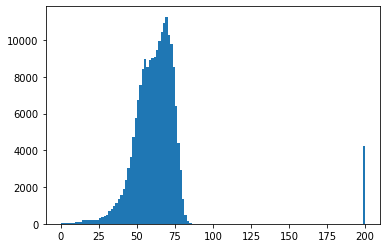

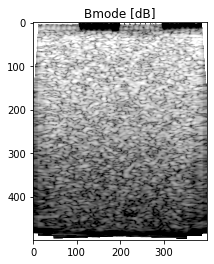

In [12]:
BmodeGenerator = GenerateBmode()
BmodeGenerator.prepare()
Bmode = BmodeGenerator.process(data=hri_data[5, :, :])
BmodeGenerator.plotHistogram(Bmode)
BmodeGenerator.displayBmode(frame=Bmode, dB_range=[40, 80])


# Shear wave detection

In [13]:
# Crop the data
hri_data = np.moveaxis(hri_data, [0,1], [2,1])
print(hri_data.shape)

(500, 400, 146)


In [14]:
# Shear wave detection
ShearDetector = ShearwaveDetection(mode=swd_mode, packet_size=swd_ensemble_length, z_gate=swd_zGate_length, frame_pri=pwi_fri, c=c, fc=pwi_txFreq, fs=fs)
ShearDetector.prepare()
ddata = ShearDetector.process(data=hri_data)

(499, 400, 145)


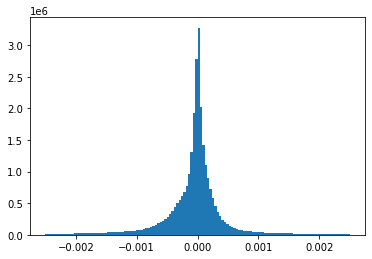

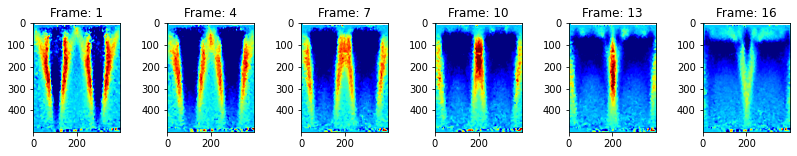

In [15]:
getHistogram(data=ddata, Vrange = [-2.5e-3, 2.5e-3])
print(ddata.shape)
DrawShearWaveFrames(data=ddata, Vrange=[-2e-3, 4e-3], frames=[1, 4, 7, 10, 13, 16])

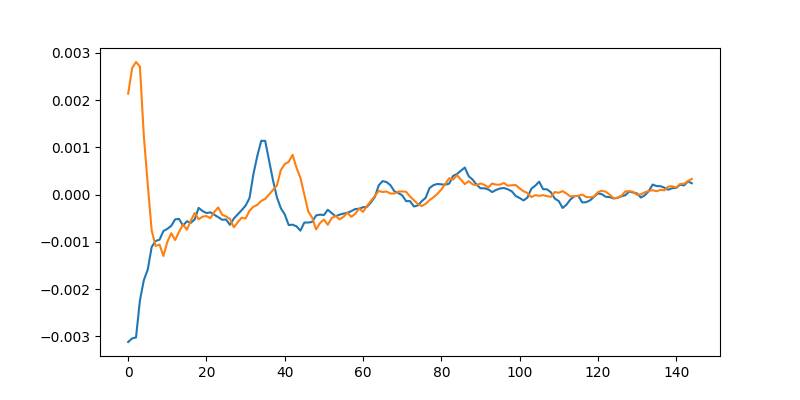

In [16]:
# Plot some profiles
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.squeeze(ddata[300, 320-15, :]))
ax.plot(np.squeeze(ddata[300, 320+15, :]))

# Shear wave motion data filtering

In [17]:
# Shear wave motion data filtering in Fourier domain
DirFilter = ShearwaveMotionDataFiltering(data_shape = ddata.shape, sws_range=df_sws_range, f_range=df_f_range, k_range=df_k_range, fs=1.0/pwi_fri)
DirFilter.prepare()
(ddata_LR, ddata_RL) = DirFilter.process(data=ddata)

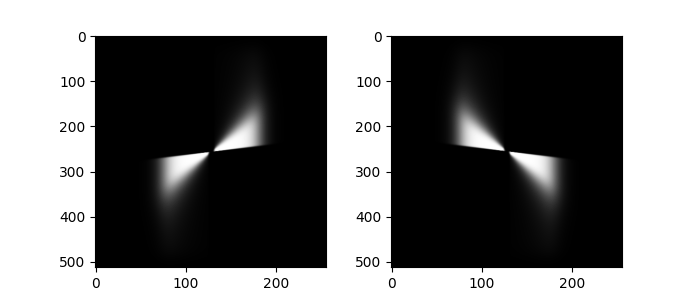

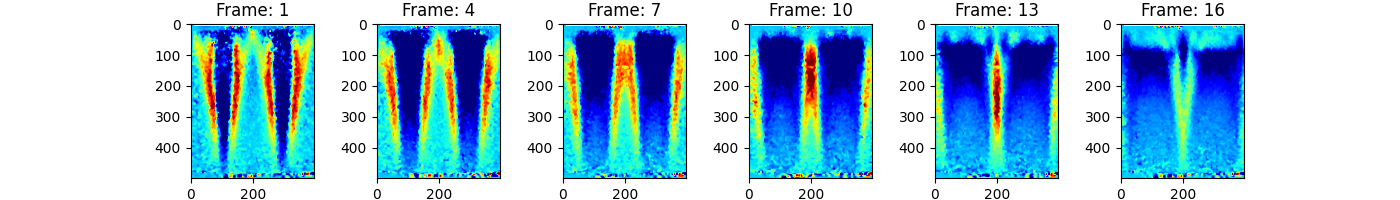

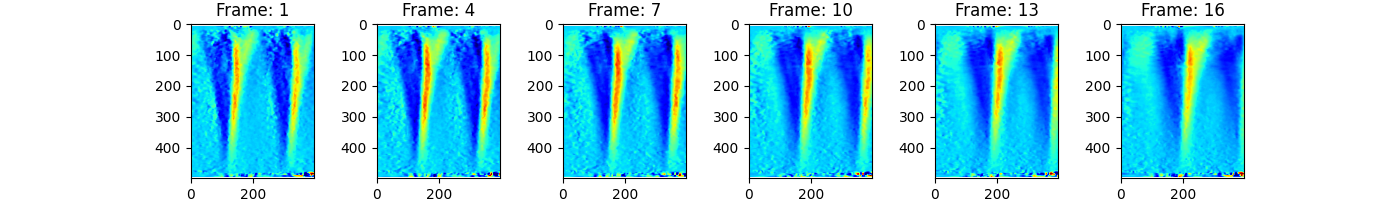

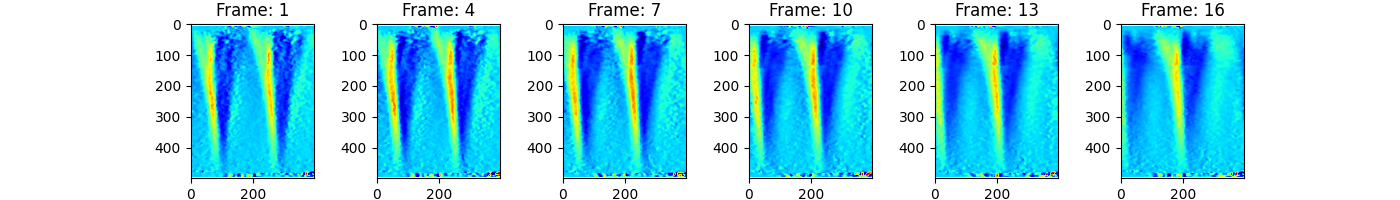

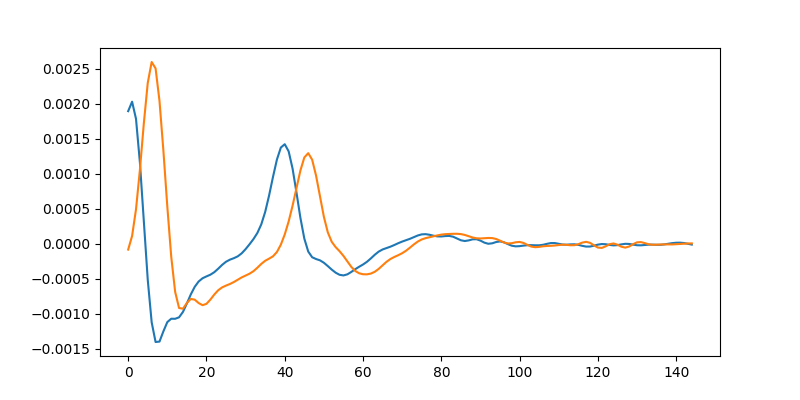

In [18]:
## Visualize results
# Filter masks
DirFilter.plotFilterMasks()
# Filtered motion data frames
DrawShearWaveFrames(data=ddata,    Vrange=[-2e-3, 4e-3], frames=[1, 4, 7, 10, 13, 16])
DrawShearWaveFrames(data=ddata_LR, Vrange=[-2e-3, 4e-3], frames=[1, 4, 7, 10, 13, 16])
DrawShearWaveFrames(data=ddata_RL, Vrange=[-2e-3, 4e-3], frames=[1, 4, 7, 10, 13, 16])
# Plot some profiles
#%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.squeeze(ddata_LR[200, 350-15, :]))
ax.plot(np.squeeze(ddata_LR[200, 350+15, :]))

# Local shear wave speed estimation

## FFT-based correlation approach

In [19]:
# SWS estimation
ddata_LR = ddata_LR[10:-30, :, swse_frames[0]:swse_frames[1]] 
ddata_RL = ddata_RL[10:-30, :, swse_frames[0]:swse_frames[1]] 

In [20]:
dim = ddata_LR.shape
print(dim)
SWS   = np.zeros((2, dim[0], dim[1]))
SWS_r = np.zeros((2, dim[0], dim[1]))

SWS_Estimator0 = SWS_Estimation(data_shape=ddata_LR.shape, x_range=swse_x_range[0], d=swse_d, interp_factor=swse_interp_factor, interp_type=swse_interp_type, 
                                px_pitch=0.1e-3, FRI =pwi_fri, sws_range=swse_SWV_range)
SWS_Estimator1 = SWS_Estimation(data_shape=ddata_RL.shape, x_range=swse_x_range[1], d=swse_d, interp_factor=swse_interp_factor, interp_type=swse_interp_type, 
                                px_pitch=0.1e-3, FRI =pwi_fri, sws_range=swse_SWV_range)
#LR
SWS_Estimator0.prepare()
(SWS[0,:,:], SWS_r[0,:,:]) = SWS_Estimator0.process(data=ddata_LR)
#RL
SWS_Estimator1.prepare()
(SWS[1,:,:], SWS_r[1,:,:]) = SWS_Estimator1.process(data=ddata_RL)

(459, 400, 99)


Text(0.5, 1.0, 'r_RL')

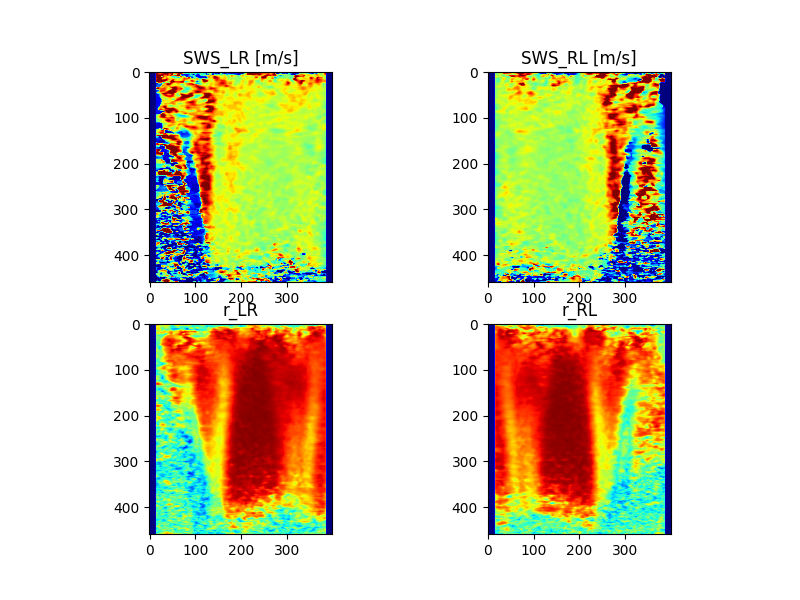

In [21]:
#Visualize the results
#norm_sws = plt.Normalize(swse_SWV_range[0], swse_SWV_range[1], True)
norm_r   = plt.Normalize(0, 1, True)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axs[0,0].imshow(np.squeeze(SWS[0,:,:]), cmap='jet')#, norm=norm_sws)
axs[0,0].set_title('SWS_LR [m/s]')

axs[1,0].imshow(np.squeeze(SWS_r[0,:,:]), cmap='jet', norm=norm_r)
axs[1,0].set_title('r_LR')

axs[0,1].imshow(np.squeeze(SWS[1,:,:]), cmap='jet')#, norm=norm_sws)
axs[0,1].set_title('SWS_RL [m/s]')

axs[1,1].imshow(np.squeeze(SWS_r[1,:,:]), cmap='jet', norm=norm_r)
axs[1,1].set_title('r_RL')


# Post-processing

## Image compounding

In [22]:
print(SWS.shape)
# Pack data
SWS = SWS[np.newaxis, ...]
SWS_r = SWS_r[np.newaxis, ...]

SWS_data = np.concatenate((SWS, SWS_r), axis=0)
print(SWS_data.shape)

(2, 459, 400)
(2, 2, 459, 400)


In [23]:
SWS_Compounder = SWS_Compounding()
SWS_Compounder.prepare()
(SWSc, SWScr) = SWS_Compounder.process(SWS_data)

Text(0.5, 1.0, 'r [m/s]')

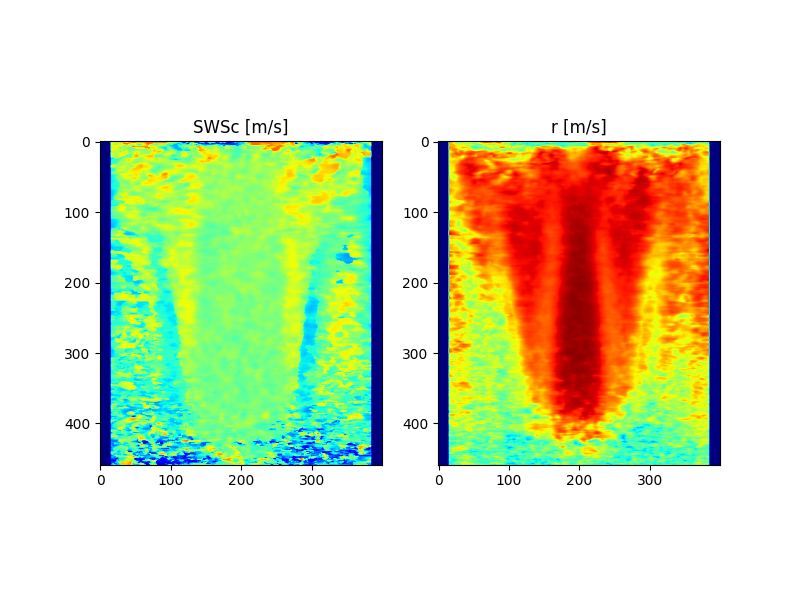

In [24]:
# Visualize results
norm_r   = plt.Normalize(0, 2, True)
norm_sws = plt.Normalize(swse_SWV_range[0], swse_SWV_range[1], True)
norm_sws = plt.Normalize(0, 5, True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
axs[0].imshow(np.squeeze(SWSc), cmap='jet', norm=norm_sws)
axs[0].set_title('SWSc [m/s]')

axs[1].imshow(np.squeeze(SWScr), cmap='jet', norm=norm_r)
axs[1].set_title('r [m/s]')

## Image filtering

In [25]:
# Median filtering
#SWS_filtered = sp.ndimage.median_filter(SWSc, size=(median_filter_size, median_filter_size))

In [27]:
MedianFilter = MedianFiltering(kernel_size=median_filter_size)
MedianFilter.prepare()
SWS_filtered = MedianFilter.process(SWSc)

## Data presentation

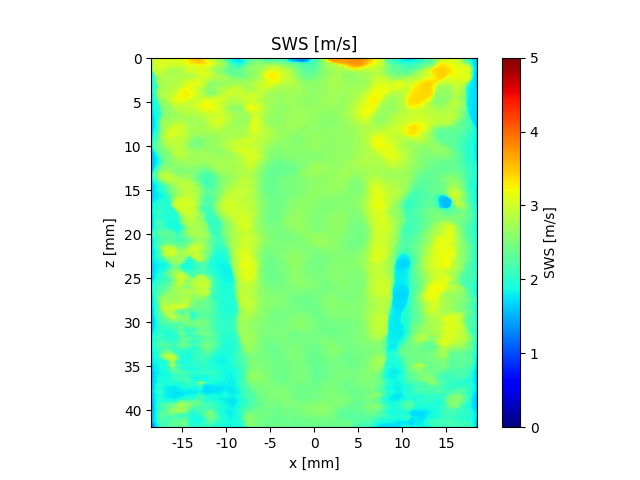

In [28]:
# Visualize SWS map
plotSWSmap(data=SWS_filtered[:420, swse_d//2:-swse_d//2], px_size=px_size, tick_grid_size=[5, 5], sws_disp_range=[0, 5])